In [1]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart, draw_bar_chart
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

polars.config.Config

In [2]:
POJISTOVNA = "ozp"
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

In [3]:
datum_zahajeni_pojisteni_map = {}
for person in persons:
    if person.zahajeni_pojisteni < datetime(1980, 1, 1).date():
        continue
    if person.zahajeni_pojisteni not in datum_zahajeni_pojisteni_map:
        datum_zahajeni_pojisteni_map[person.zahajeni_pojisteni] = 1
    else:
        datum_zahajeni_pojisteni_map[person.zahajeni_pojisteni] += 1

draw_chart(
    mapp=datum_zahajeni_pojisteni_map,
    x_label="Datum zahájení pojištění",
    y_label="Počet lidí",
    title="Počet lidí s daným datem zahájení pojištění",
    average=False,
    save_location="./out/datum_zahajeni_pojisteni.png",
)

✓ Chart saved: ./out/datum_zahajeni_pojisteni.png


In [4]:
datum_ukonceni_pojisteni_map = {}
for person in persons:
    if not person.ukonceni_pojisteni:
        continue
    if (
        person.ukonceni_pojisteni < datetime(1980, 1, 1).date()
        or person.ukonceni_pojisteni > datetime(2026, 1, 1).date()
    ):
        continue
    if person.ukonceni_pojisteni not in datum_ukonceni_pojisteni_map:
        datum_ukonceni_pojisteni_map[person.ukonceni_pojisteni] = 1
    else:
        datum_ukonceni_pojisteni_map[person.ukonceni_pojisteni] += 1

draw_chart(
    mapp=datum_ukonceni_pojisteni_map,
    x_label="Datum ukončení pojištění",
    y_label="Počet lidí",
    title="Počet lidí s daným datem ukončení pojištění",
    average=False,
    save_location="./out/datum_ukonceni_pojisteni.png",
)

✓ Chart saved: ./out/datum_ukonceni_pojisteni.png


In [5]:
pocet_prvopredpisu_map = defaultdict(int)
for person in persons:
    if person.prescriptions:
        min_prescription = min(person.prescriptions, key=lambda x: x.date)
        pocet_prvopredpisu_map[min_prescription.date] += 1

draw_chart(
    mapp=pocet_prvopredpisu_map,
    x_label="Datum prvního předpisu",
    y_label="Počet prvopředpisů za den",
    title="Počet prvopředpisů",
    average=30,
    save_location="./out/pocet_prvopredpisu.png",
)

✓ Chart saved: ./out/pocet_prvopredpisu.png


In [6]:
pocet_prvopredpisu_map = defaultdict(int)
for person in persons:
    if person.prescriptions:
        min_prescription = min(person.prescriptions, key=lambda x: x.date)
        if min_prescription.date < datetime(2016, 1, 1).date():
            continue
        if person.zahajeni_pojisteni + timedelta(days=60) < min_prescription.date:
            pocet_prvopredpisu_map[min_prescription.date] += 1

draw_chart(
    mapp=pocet_prvopredpisu_map,
    x_label="Datum prvního předpisu",
    y_label="Počet prvopředpisů za den",
    title="Počet prvopředpisů (Vyřazený první rok + lidé, kteří měnili pojišťovnu v posledním roce)",
    average=30,
    save_location="./out/pocet_upravenych_prvopredpisu.png",
)

✓ Chart saved: ./out/pocet_upravenych_prvopredpisu.png


In [7]:
datum_s_kort_ekvivalenty = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.prednison_equiv is None:
            continue
        if prescription.date not in datum_s_kort_ekvivalenty:
            datum_s_kort_ekvivalenty[prescription.date] = prescription.prednison_equiv
        else:
            datum_s_kort_ekvivalenty[prescription.date] += prescription.prednison_equiv

draw_chart(
    mapp=datum_s_kort_ekvivalenty,
    x_label="Datum předpisu",
    y_label="Počet kortikoidových ekvivalentů",
    title="Počet kortikoidových ekvivalentů za den",
    average=False,
    save_location="./out/pocet_kortikoidovych_ekvivalentu.png",
)

✓ Chart saved: ./out/pocet_kortikoidovych_ekvivalentu.png


In [8]:
datum_s_imunosupresivy = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.prescription_type != PrescriptionType.IMUNOSUPRESSIVE:
            continue
        if prescription.date not in datum_s_imunosupresivy:
            datum_s_imunosupresivy[prescription.date] = 1
        else:
            datum_s_imunosupresivy[prescription.date] += 1

draw_chart(
    mapp=datum_s_imunosupresivy,
    x_label="Datum předpisu",
    y_label="Počet imunosupresivních předpisů za den",
    title="Počet imunosupresivních předpisů",
    average=183,
    save_location="./out/pocet_imunosupresiv.png",
)

✓ Chart saved: ./out/pocet_imunosupresiv.png


In [9]:
datum_s_kortikoidy = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if (
            prescription.prescription_type != PrescriptionType.KORTIKOID
            or not prescription.prednison_equiv
        ):
            continue
        if prescription.date not in datum_s_kortikoidy:
            datum_s_kortikoidy[prescription.date] = 1
        else:
            datum_s_kortikoidy[prescription.date] += 1

draw_chart(
    mapp=datum_s_kortikoidy,
    x_label="Datum předpisu",
    y_label="Počet kortikoidových předpisů za den",
    title="Počet kortikoidových předpisů",
    average=183,
    save_location="./out/pocet_kortikoidovych_predpisu.png",
)

✓ Chart saved: ./out/pocet_kortikoidovych_predpisu.png


In [10]:
datum_predpisu = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.date not in datum_predpisu:
            datum_predpisu[prescription.date] = 1
        else:
            datum_predpisu[prescription.date] += 1

draw_chart(
    mapp=datum_predpisu,
    x_label="Datum předpisu",
    y_label="Počet předpisů za den",
    title="Počet předpisů",
    average=183,
    save_location="./out/pocet_predpisu.png",
)

✓ Chart saved: ./out/pocet_predpisu.png


In [11]:
datum_umrti = {}
for person in persons:
    if not person.died_at:
        continue
    if person.died_at not in datum_umrti:
        datum_umrti[person.died_at] = 1
    else:
        datum_umrti[person.died_at] += 1

draw_chart(
    mapp=datum_umrti,
    x_label="Datum úmrtí",
    y_label="Počet lidí",
    title="Počet lidí s daným datem úmrtí",
    average=None,
    save_location="./out/pocet_umrti.png",
)

✓ Chart saved: ./out/pocet_umrti.png


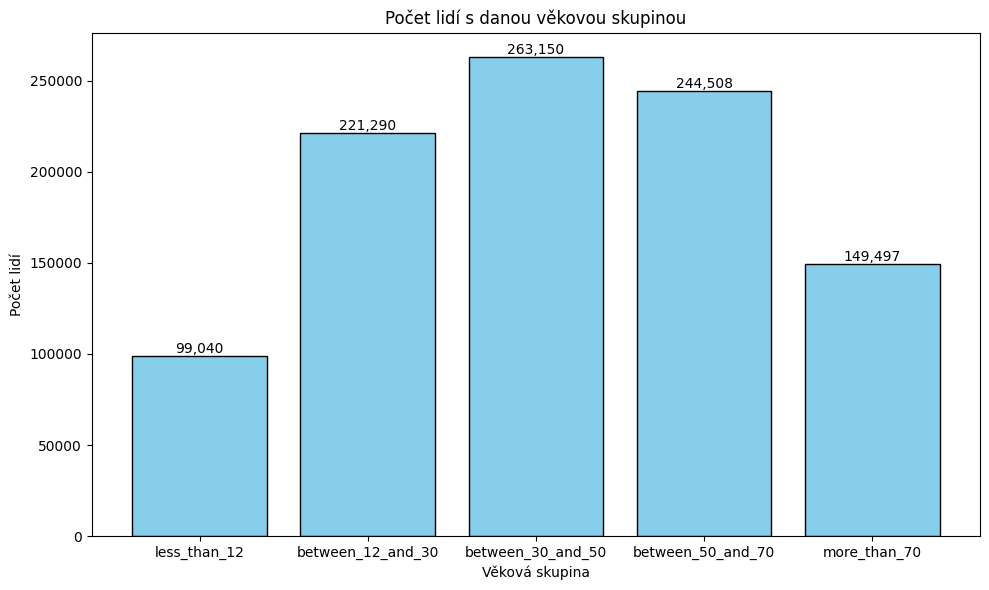

In [12]:
age_cohort_map = {
    AgeCohort.LESS_THAN_12: 0,
    AgeCohort.BETWEEN_12_AND_30: 0,
    AgeCohort.BETWEEN_30_AND_50: 0,
    AgeCohort.BETWEEN_50_AND_70: 0,
    AgeCohort.MORE_THAN_70: 0,
}
for person in persons:
    age_cohort_map[person.age_cohort] += 1

draw_bar_chart(
    mapp=age_cohort_map,
    x_label="Věková skupina",
    y_label="Počet lidí",
    title="Počet lidí s danou věkovou skupinou",
    save_location="./out/věková_skupina.png",
)

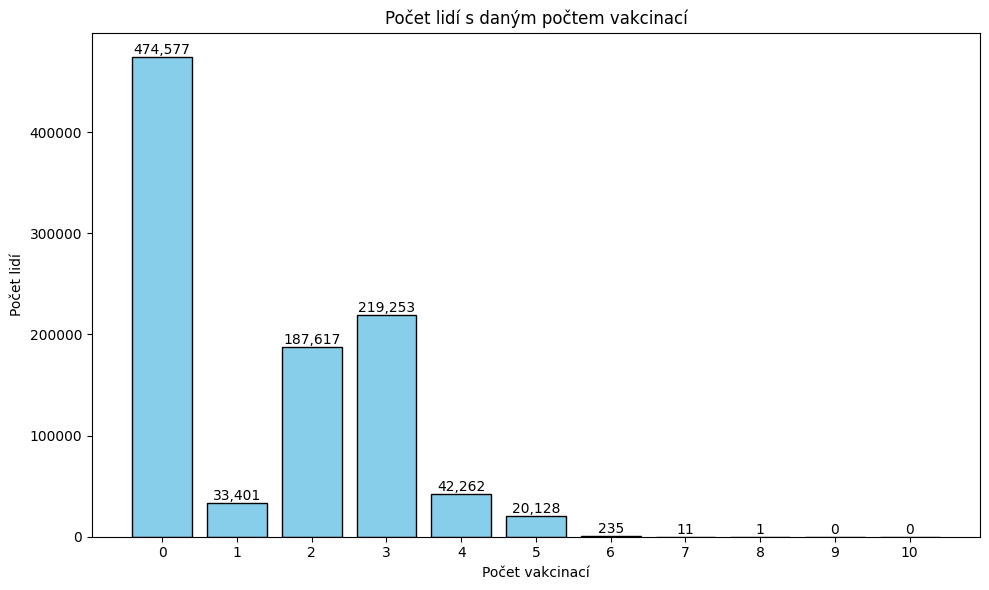

In [13]:
pocet_vakcin_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
}
for person in persons:
    pocet_vakcin_map[len(person.vaccines)] += 1

draw_bar_chart(
    mapp=pocet_vakcin_map,
    x_label="Počet vakcinací",
    y_label="Počet lidí",
    title="Počet lidí s daným počtem vakcinací",
    save_location="./out/pocet_lidi_s_urcitym_poctem_vakcinací.png",
)

In [14]:
pocet_predpisu_map = defaultdict(int)
for person in persons:
    if len(person.prescriptions) > 800:
        print(person)
    if len(person.prescriptions) > 20:
        continue
    pocet_predpisu_map[len(person.prescriptions)] += 1

draw_chart(
    mapp=pocet_predpisu_map,
    x_label="Počet předpisů",
    y_label="Počet lidí",
    title="Počet lidí s daným počtem předpisů",
    save_location="./out/pocet_lidi_s_poctem_predpisu.png",
)

Person(id='ANPOJ00885267', gender=<Gender.MALE: 'male'>, born_at=datetime.datetime(1953, 1, 1, 0, 0), zahajeni_pojisteni=datetime.date(1994, 1, 1), ukonceni_pojisteni=None, age_cohort=<AgeCohort.MORE_THAN_70: 'more_than_70'>, vaccines=[Vaccine(date=datetime.date(2021, 4, 24), dose_number=1, age_cohort=<AgeCohort.BETWEEN_50_AND_70: 'between_50_and_70'>), Vaccine(date=datetime.date(2021, 6, 5), dose_number=2, age_cohort=<AgeCohort.BETWEEN_50_AND_70: 'between_50_and_70'>), Vaccine(date=datetime.date(2021, 12, 3), dose_number=3, age_cohort=<AgeCohort.BETWEEN_50_AND_70: 'between_50_and_70'>)], prescriptions=[Prescription(date=datetime.date(2015, 1, 2), latka='NATRIUM-HYDROKORTISON-SUKCINÁT', age_cohort_at_prescription=<AgeCohort.BETWEEN_50_AND_70: 'between_50_and_70'>, prescription_type=<PrescriptionType.KORTIKOID: 'kortikoid'>, equiv_sloucenina='HYDROKORTISON', prednison_equiv=0.25, specializace_lekare=None, atc_skupina='H02AB09', lekova_forma='Prášek pro injekční roztok'), Prescription(da